<a href="https://colab.research.google.com/github/mineramc/GTSRB_image_recognition/blob/master/GTSRB_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import os
import cv2
from PIL import Image, ImageOps

Load Data from Kaggle

> remember to load kaggle.json

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.


In [2]:
! pip install kaggle;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 598M/612M [00:06<00:00, 103MB/s]
100% 612M/612M [00:06<00:00, 99.1MB/s]


In [7]:
! mkdir data

In [8]:
! unzip gtsrb-german-traffic-sign.zip -d data > /dev/null 2>&1

Data Setup


1. training and testing images are imported and converted from NumPy array to PIL image.
2.    images are resized to the same height and width and training images are shuffled. Meanwhile, labels for training and testing image data are also retrieved and stored as arrays.
3.   Also, images are normalized by dividing 255 (since image pixel values range from 0 to 256).
4.   Since the RF and SVM algorithms from scikit-learn expect the inputs to be 2D array, the read-in images (with 4 dimensions) are then reshaped to 2D.
5. Fit the random forest and SVM using train data and make predictions with test data. Confusion matrix and classification accuracy are obtained for all three types of input images.








In [9]:
data_dir = '/content/data'
train_path = '/content/data/Train'
test_path = '/content/data/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

num_classes = len(os.listdir(train_path))
num_classes

43

Load Training Data

In [10]:
image_data = []
image_labels = []
grey_data = []

# Read in training data
for i in range(num_classes):
    path = train_path + '/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            grey_img = ImageOps.grayscale(resize_image)
            image_data.append(np.array(resize_image))
            image_labels.append(i)
            grey_data.append(np.array(grey_img))
        except:
            print("Error in " + img)

# list -> numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)
grey_data = np.array(grey_data)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [11]:
shuffle_indexes = np.arange(image_data.shape[0]) #return numpy array [0,1,2,...,39206,39207,39208]
# image_data.shape = (39209, 30, 30, 3)
np.random.shuffle(shuffle_indexes) # shuffles index

# shuffles the data with shuffled indices
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]
grey_data = grey_data[shuffle_indexes]

X_train = image_data
y_train = image_labels
grey_X_train = grey_data

Load Test Data

In [12]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []
greyscale_data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        greyscale_img = ImageOps.grayscale(resize_image)
        data.append(np.array(resize_image))
        greyscale_data.append(np.array(greyscale_img))
    except:
        print("Error in " + img)

X_test = np.array(data)
y_test = labels
grey_X_test = np.array(greyscale_data)


In [13]:
# normalize data by dividing by 255 so values are between 0 and 1 making computation more efficient
X_train, X_test= X_train/255, X_test/255
grey_X_train, grey_X_test = grey_X_train/255, grey_X_test/255

Reshape 4d array -> 2d for sklearn model

In [14]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array
nsamples, nx, ny, nrgb = X_train.shape
X_train2 = X_train.reshape((nsamples, nx*ny*nrgb))

#so,eventually,model.predict() should also be a 2d input
nsamples, nx, ny, nrgb = X_test.shape
X_test2 =  X_test.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny = grey_X_train.shape
grey_X_train2 = grey_X_train.reshape((nsamples, nx*ny))

nsamples, nx, ny = grey_X_test.shape
grey_X_test2 = grey_X_test.reshape((nsamples, nx*ny))

# new array is nrows = number of images, ncols = number of pixels per image

Generating SVM

SVM for original images

In [ ]:
from sklearn.svm import SVC


#Create a svm Classifier
svm = SVC(kernel='linear', gamma='auto') # Linear Kernel

#Train the model using the training sets
svm.fit(X_train2, y_train)

#Predict the response for test dataset
y_pred = svm.predict(X_test2)



In [ ]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8227236737925574


Text(0.5, 48.25, 'Predicted label')

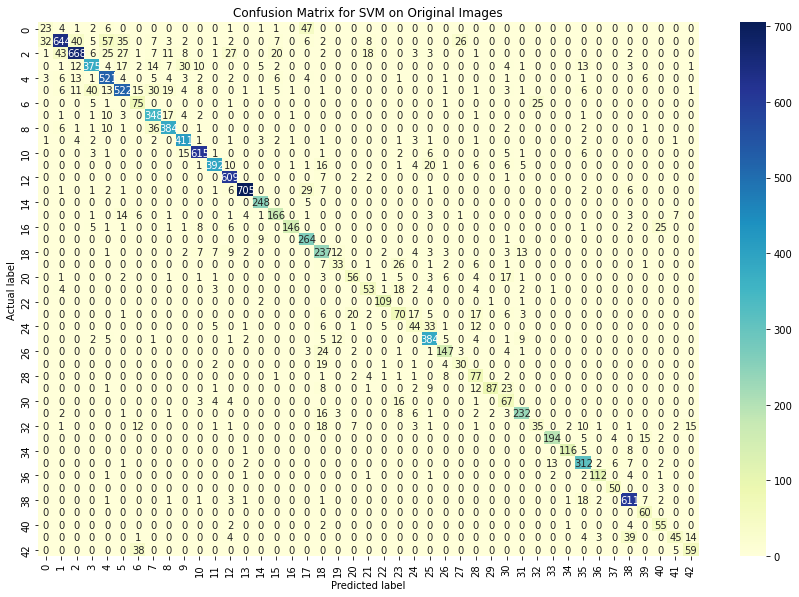

In [ ]:
conf_mat_svm = confusion_matrix(y_pred, y_test)

#obtain the confusion matrix heatmap

class_names = [0,1]

plt.figure(figsize=(12,8))
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

sns.heatmap(pd.DataFrame(conf_mat_svm), annot=True,cmap='YlGnBu',fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for SVM on Original Images', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

SVM for greyscale images

In [ ]:
from sklearn.svm import SVC

#Create a svm Classifier
grey_svm = SVC(kernel='linear', gamma='auto') # Linear Kernel

#Train the model using the training sets
grey_svm.fit(grey_X_train2, y_train)

In [18]:
#Predict the response for test dataset
grey_y_pred = grey_svm.predict(grey_X_test2)

In [19]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, grey_y_pred))

Accuracy: 0.8262866191607284


Text(0.5, 48.25, 'Predicted label')

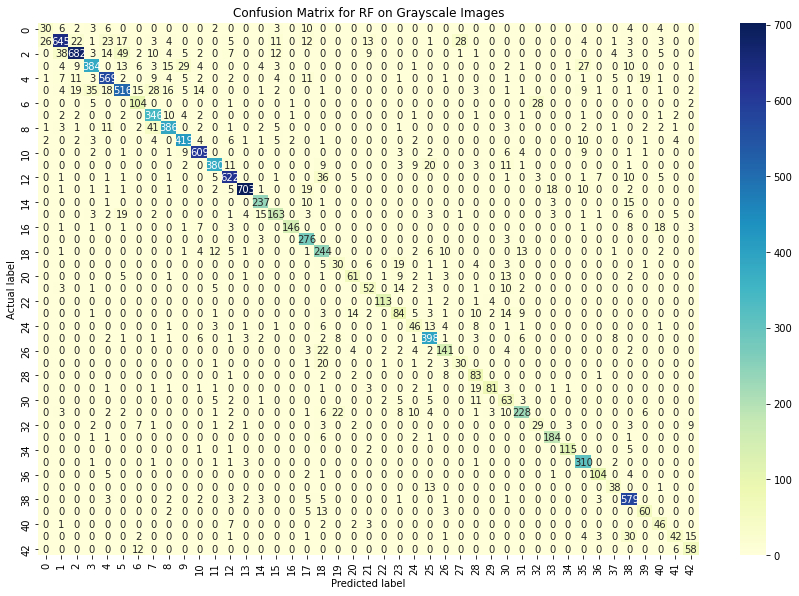

In [20]:
#obtain the confusion matrix heatmap
conf_mat_svm_gray = confusion_matrix(grey_y_pred, y_test)
class_names = [0,1]

plt.figure(figsize=(12,8))
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

sns.heatmap(pd.DataFrame(conf_mat_svm_gray), annot=True,cmap='YlGnBu',fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for RF on Grayscale Images', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')